# Introduction

Financial fraud poses a serious threat to digital transactions, especially with the rise of online banking and money transfers. This project aims to build a machine learning model that can detect fraudulent transactions using real-world financial data. By analyzing patterns in transaction types, amounts, and timing, and applying techniques like SMOTE, threshold tuning, and SHAP explanations, we create a robust and interpretable fraud detection system. The goal is to help financial institutions reduce risk and respond faster to suspicious activity.

# Metadata

**'step'** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**'type'** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**'amount'** - amount of the transaction in local currency.

**'nameOrig'** - customer who started the transaction

**'oldbalanceOrg'** - initial balance before the transaction

**'newbalanceOrig'** - new balance after the transaction

**'nameDest'** - customer who is the recipient of the transaction

**'oldbalanceDest'** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**'newbalanceDest'** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**'isFraud'** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**'isFlaggedFraud'** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
# !pip install -U scikit-learn imbalanced-learn xgboost
# !pip uninstall -q -y category-encoders cesium
!pip install -q -U scikit-learn imbalanced-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 75.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import joblib
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (train_test_split,
StratifiedKFold, GridSearchCV)

from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (accuracy_score,
precision_score, recall_score, f1_score, roc_auc_score,
classification_report, ConfusionMatrixDisplay)

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category = UserWarning)

# Exploratory Data Analysis

In [3]:
df = pd.read_csv("/kaggle/input/frauds/Fraud.csv")

In [4]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
df.info(show_counts =True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
# Removing Duplicate Observations
df.drop_duplicates(inplace=True)

In [9]:
# Checking balance in fraud and not fraud observations
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [10]:
# Transactions above 2lakhs that are flagged fraud
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

# Class Imbalance

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


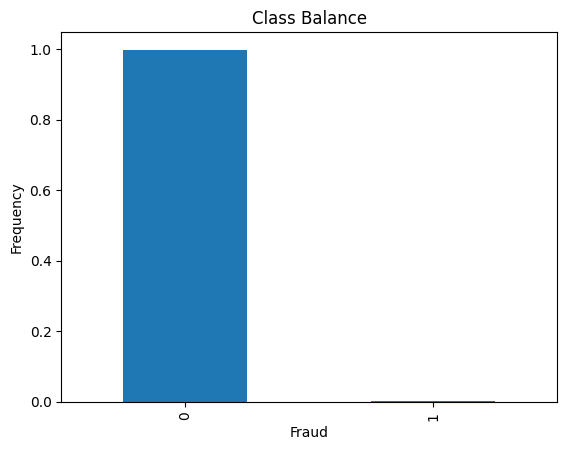

In [11]:

print(df['isFraud'].value_counts(normalize=True)*100)
df['isFraud'].value_counts(normalize=True).plot(
    kind = 'bar',
    xlabel = 'Fraud',
    ylabel = 'Frequency',
    title = 'Class Balance'
);

# Data Distribution 

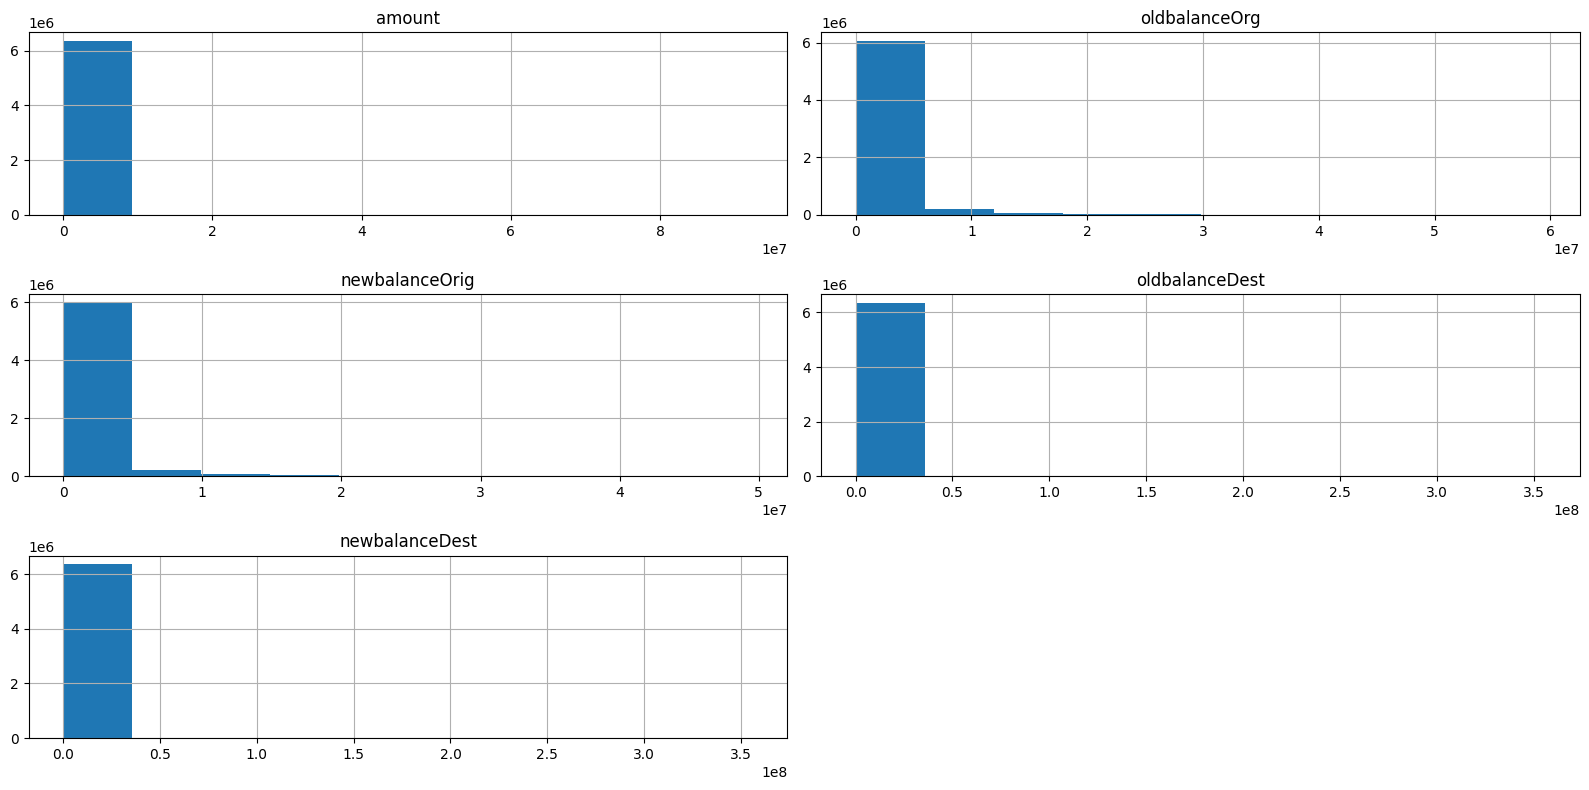

In [12]:
df.drop(columns=['step','isFraud','isFlaggedFraud']).hist(figsize=(16,8))
plt.tight_layout()
plt.show()

# Outliers

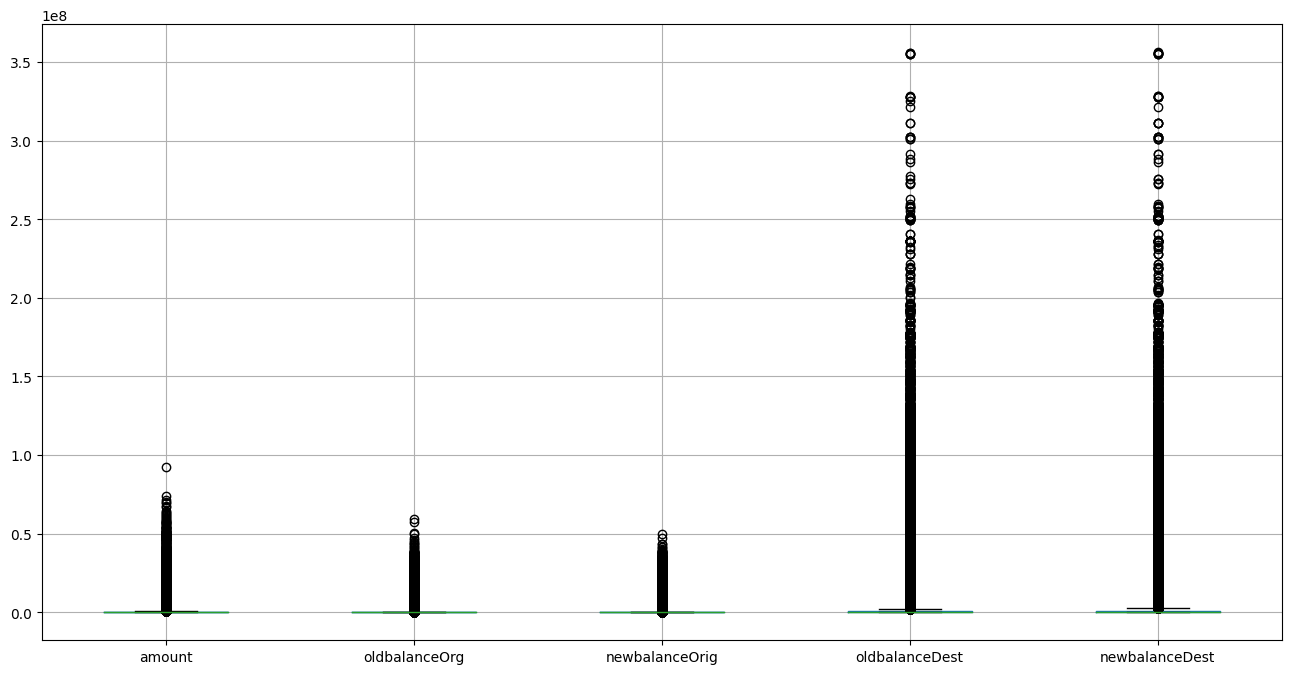

In [13]:
df.drop(columns=['step','isFraud','isFlaggedFraud']).boxplot(figsize=(16,8))
plt.show()

# Feature Engineering

In [14]:
# Create net balance change features
df['deltaOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Extract time-based features from 'step'
df['hour'] = df['step'] % 24
df['day'] = df['step'] // 24
df['is_night'] = df['hour'].apply(lambda x: 1 if x < 6 or x > 22 else 0)

# One-hot encode 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Drop irrelevant columns
df.drop(columns=['step','nameOrig', 'nameDest',
                 'oldbalanceOrg', 'newbalanceOrig',
                 'oldbalanceDest', 'newbalanceDest',
                'isFlaggedFraud'],
        inplace=True)

# Preview engineered features
df.tail()


,amount,isFraud,deltaOrig,deltaDest,hour,day,is_night,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
6362615,339682.13,1,339682.13,339682.13,23,30,1,True,False,False,False
6362616,6311409.28,1,6311409.28,0.00,23,30,1,False,False,False,True
6362617,6311409.28,1,6311409.28,6311409.27,23,30,1,True,False,False,False
6362618,850002.52,1,850002.52,0.00,23,30,1,False,False,False,True
6362619,850002.52,1,850002.52,850002.52,23,30,1,True,False,False,False


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   amount         float64
 1   isFraud        int64  
 2   deltaOrig      float64
 3   deltaDest      float64
 4   hour           int64  
 5   day            int64  
 6   is_night       int64  
 7   type_CASH_OUT  bool   
 8   type_DEBIT     bool   
 9   type_PAYMENT   bool   
 10  type_TRANSFER  bool   
dtypes: bool(4), float64(3), int64(4)
memory usage: 364.1 MB


# Heatmap

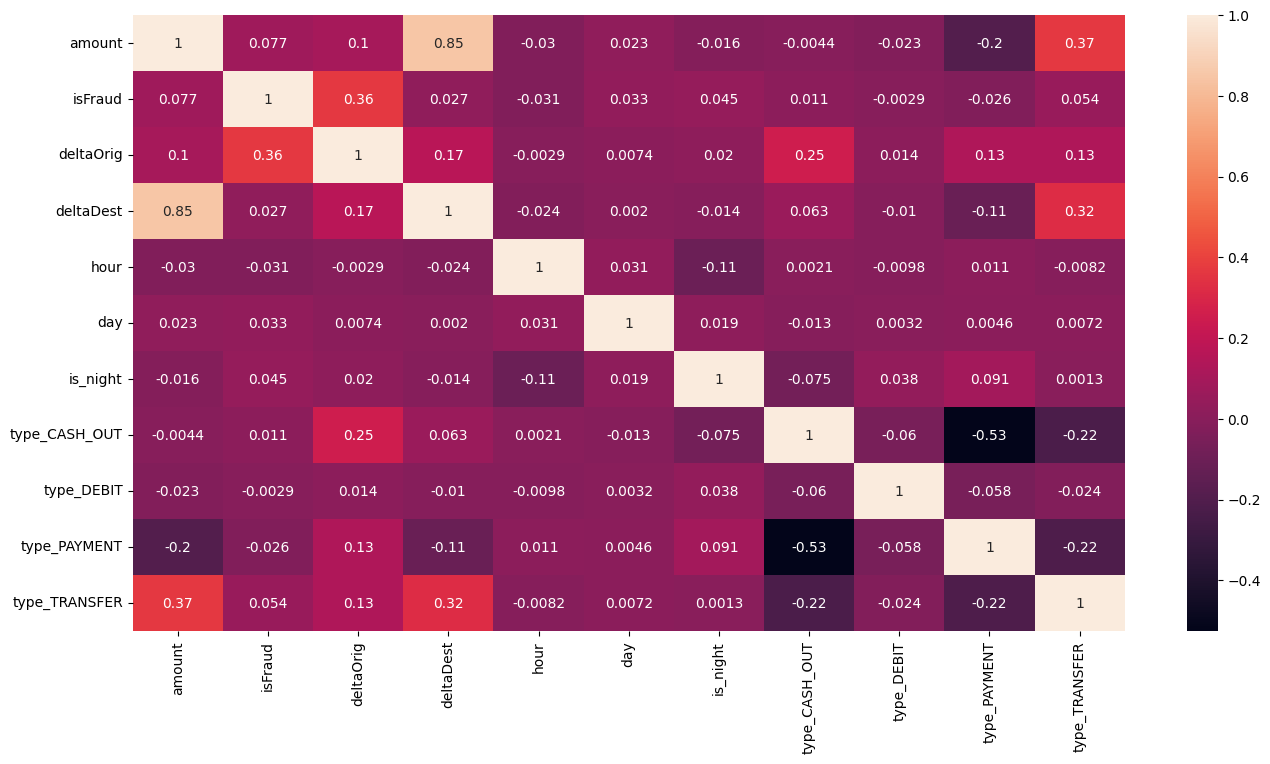

In [16]:
corr = df.corr()
plt.figure(figsize=(16,8))
sns.heatmap(corr,annot=True);

# Variance Inflation Factor(VIF)

In [17]:
# Drop original highly correlated features
X = df.drop(columns=[
    'isFraud']
    )

# Ensure all columns are numeric
X = X.select_dtypes(include=['number'])

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data


,Feature,VIF
0,amount,3.837639
1,deltaOrig,1.056103
2,deltaDest,3.690121
3,hour,3.139630
4,day,3.113277
5,is_night,1.034540


### Data cleaning including missing values, outliers and multi-collinearity.

* For data cleaning and missing values:
  - There was no duplicate observations.
  - There was no missing values.
---
* For Outliers:
  - There was some outliers.
  - But as it was account balance can't treat them as outliers.
---


* For Multi-collinearity:
  - Developed a new feature with difference of Old and New balance of Destination and Origin account balance.
  - The actual new and old balance features were removed.
  - Calculated Variance Inflation Factor(VIF) which should be <10.




### Variable Selection

To build a robust fraud detection model, I selected variables using a structured approach:

- **EDA insights**: Removed highly correlated features and retained those with strong fraud signal.
- **VIF analysis**: Dropped multicollinear variables to improve model stability.
- **Feature engineering**: Added Account Balance difference, hour of the day and time-based flags.
- **Threshold tuning**: Evaluated features based on impact on precision, recall, and F1-score.

### Model Performance 

- **Metrics Used**: Precision, Recall, F1-Score, ROC-AUC, Confusion Matrix
- **Threshold Tuning**: GridSearchCV using GPU to optimize fraud detection
- **Model Comparison**: Random Forest outperformed Logistic Regression and XGBoost on recall and AUC
- **Visual Tools**: Seaborn & Matplotlib for Boxplot and Histograms
- **Interpretability**: SHAP values used to explain predictions and feature impact

Final model achieved high recall with reduced false positives, making it suitable for fraud detection.


# Split

In [18]:
X = df.drop(columns = 'isFraud')
y = df['isFraud']

# split: train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


In [19]:
# Instantiate the models
model_lr = LogisticRegression()
model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_gb = GradientBoostingClassifier()
model_knn = KNeighborsClassifier()
model_xgb = XGBClassifier()

In [20]:
if False:
        
    # Dictionary for the models
    models = {
        "Logistic Regression": model_lr,
        "Decision Tree": model_dt,
        "Random Forest": model_rf,
        "Gradient Boosting": model_gb,
        "K-Nearest Neighbors": model_knn,
        "XGBoost" : model_xgb
    }
    
    # Train and evaluate each model
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
    
        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"AUC-ROC: {roc_auc:.4f}")
        print("-------------------------------------------")


# Logistic Regression

In [21]:

# Define pipeline steps
model = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000))
])

# Fit on training data
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_test)

# Evaluate
print("Validation Performance:")
print(classification_report(y_test, y_pred))



Validation Performance:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1588602
           1       0.03      0.95      0.06      2053

    accuracy                           0.96   1590655
   macro avg       0.51      0.95      0.52   1590655
weighted avg       1.00      0.96      0.98   1590655



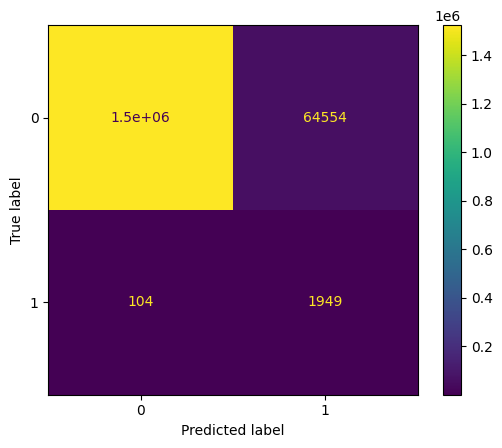

In [22]:
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test);

# RandomForestClassifier

In [23]:
if False:
    # Define pipeline steps
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100,
                                      class_weight='balanced',
                                      random_state=42))
    ])
    
    # Fit on training data
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict(X_test)
    
    # Evaluate
    print("Model Performance:")
    print(classification_report(y_test, y_pred))

# XGBoost

In [24]:
# Define pipeline
xgb= Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(
        scale_pos_weight=100,  # adjust based on imbalance ratio
        eval_metric='logloss',
        random_state=42
    ))
])

# Fit on training data
xgb.fit(X_train, y_train)

# Predict on validation set
y_pred = xgb.predict(X_test)
# y_val_probs = xgb.predict_proba(X_val)[:, 1]
# y_val_custom = (y_val_probs > 0.8).astype(int)  # Try 0.6, 0.7, 0.8

# print(classification_report(y_val, y_val_custom))


# Evaluate
print("Model Performance:")
print(classification_report(y_test, y_pred))


Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1588602
           1       0.03      0.97      0.05      2053

    accuracy                           0.96   1590655
   macro avg       0.51      0.96      0.51   1590655
weighted avg       1.00      0.96      0.98   1590655



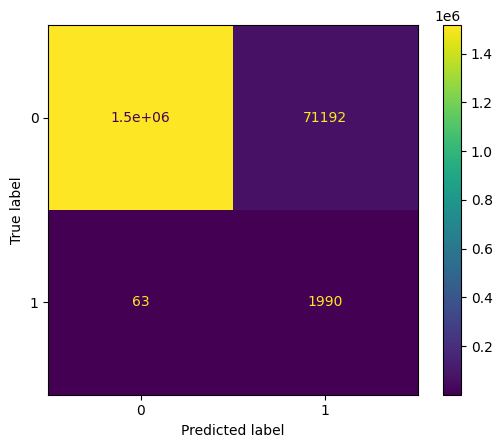

In [25]:
ConfusionMatrixDisplay.from_estimator(xgb,X_test,y_test);

# Hyperparameter Tuning XGBoost

In [26]:
print('This was run using GPU and saved model after running')
if False:
    xgb= Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('xgb', XGBClassifier(
            tree_method='hist',         # Enables GPU acceleration
            device ='cuda',
            scale_pos_weight=100,  
            eval_metric='logloss',
            random_state=42
        ))
    ])
    
    param_grid = {
        'xgb__n_estimators': [100, 300],
        'xgb__max_depth': [3,5, 7],
        'xgb__learning_rate': [0.01, 0.1],
        'xgb__subsample': [0.8, 1.0],
        'xgb__colsample_bytree': [0.6, 0.8, 1.0],
        'xgb__scale_pos_weight': [50, 100],
      
    }
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='f1',
        cv=cv,
        verbose=1,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)

This was run using GPU and saved model after running


In [27]:
# Saved Model
if False:
    joblib.dump(grid_search.best_estimator_, 'xgb_fraud_pipeline.joblib')

Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1588602
           1       0.03      0.96      0.07      2053

    accuracy                           0.96   1590655
   macro avg       0.52      0.96      0.52   1590655
weighted avg       1.00      0.96      0.98   1590655



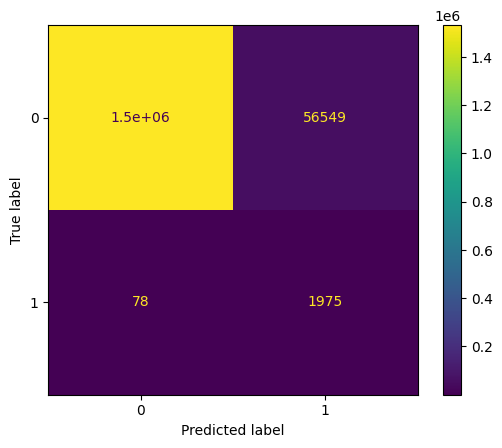

In [28]:
# Accessing saved after running it on GPU
model = joblib.load('/kaggle/input/fraud-detection/other/default/1/xgb_fraud_pipeline.joblib')
y_pred = model.predict(X_test)
print("Model Performance:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test);

# Final Model

### After observing many models best output was given by RandomForest model with default parameters

In [29]:
if False:
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

In [30]:
# Save RF Model
if False:
    joblib.dump(model, 'RFmodel.joblib')

Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.97      0.80      0.87      2053

    accuracy                           1.00   1590655
   macro avg       0.98      0.90      0.94   1590655
weighted avg       1.00      1.00      1.00   1590655



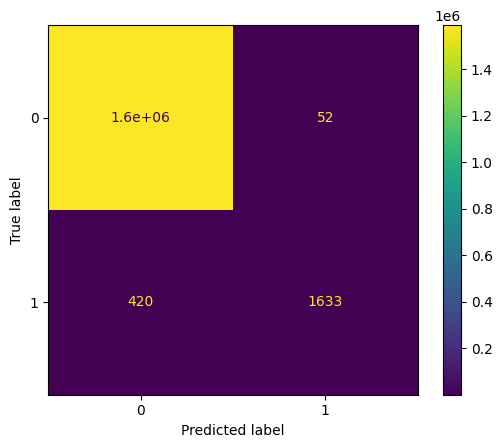

In [31]:
# Accessing saved after training and saving
model = joblib.load('/kaggle/input/fraud-detection-rf/other/default/1/RFmodel.joblib')
y_pred = model.predict(X_test)
print("Model Performance:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test);

In [32]:
model.feature_importances_

array([9.56802604e-02, 4.00477995e-01, 2.92882871e-01, 5.46095188e-02,
       1.06544617e-01, 6.21870197e-03, 1.92170365e-02, 1.03456150e-04,
       9.91075098e-04, 2.32744680e-02])

# SHAP Explanation

### SHAP Summary
- Top features like **deltaDest, type_TRANSFER, and amount** have the biggest impact on fraud prediction.

- **Red** = high values, **blue** = low values. Red dots on the right mean high values increase fraud risk.

Example: High deltaDest or amount -> more likely fraud.

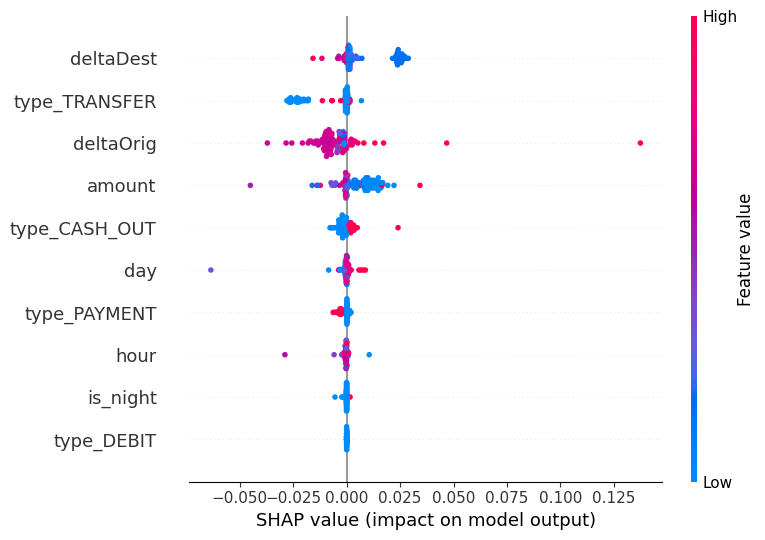

In [33]:
# Initialize SHAP
shap.initjs()

# Sample data for SHAP (for speed)
X_sample = X_test.sample(100, random_state=42).reset_index(drop=True)

# Create SHAP Explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# Visualize global feature importance
shap.summary_plot(shap_values[1], X_sample)

## SHAP Waterfall

### SHAP Waterfall Plot

- The model starts with a base value of 0.001 (very low chance of fraud).

- Each feature adds or subtracts from this base to reach the final prediction of 1 (high fraud risk).

- deltaOrig (+0.55) and deltaDest (+0.27) are the biggest contributors pushing the prediction toward fraud.

- Features like amount, type_TRANSFER, and day also add to the fraud signal.

- Minor features like hour and type_CASH_OUT slightly reduce the fraud score.

**In short:** The model sees high deltaOrig, deltaDest, and amount as strong fraud indicators for this transaction.

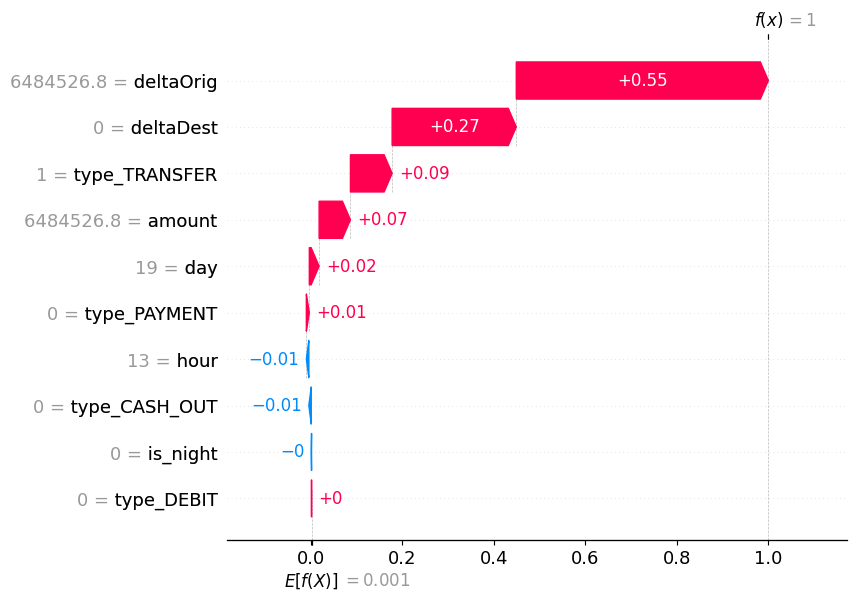

In [34]:
# Sample and clean data
X_sample = X_test.sample(100, random_state=30).astype(float).reset_index(drop=True)

# Using TreeExplainer for Random Forest
explainer = shap.TreeExplainer(model)

# Get raw SHAP values
shap_values = explainer.shap_values(X_sample)

# Create Explanation object for class 1
explanation = shap.Explanation(
    values=shap_values[1][73],
    base_values=explainer.expected_value[1],
    data=X_sample.iloc[73],
    feature_names=X_sample.columns.tolist()
)

# Plot waterfall
shap.plots.waterfall(explanation)


### Key Factors That Predict Fraudulent Customers

**'deltaDest'**: Sudden increase or no increase in destination balance signals suspicious routing.

**'deltaOrig'**: Large drop or no change in origin account balance post-transaction.

**'amount'**: High transaction amounts often linked to fraud.

**'type_TRANSFER'**: Transfers are irreversible and commonly exploited.

**'type_CASH_OUT'**: Cash-outs used for siphoning or laundering funds.

**'is_night'**: Night-time transactions may bypass manual checks.

These were identified using SHAP values and model interpretation.



### Fraud detection model in elaboration.

1. **Preprocessing:**
- No Missing Values
- No outliers
- VIF analysis to remove multicollinearity.

2. **Feature Engineering:**
- Derived Account balance difference
- Derived hour, day, is_night feature from step feature.
- One hot encoded the categorical feature type of transaction.

3. **Model Tuning:**
- Performed many model training such as
  - LogisticRegression
  - XGBClassifier
  - DecisionTreeClassifier
  - RandomForestClassifier
  - GradientBoostingClassifier
  - KNeighborsClassifier
- At first trained with default parameters
- Performed OverSampling using SMOTE
- Then performed HyperParameter Tuning with GridSearchCV to find optimum parameters such as n_estimators, max_depth, min_samples_split
- Used GPU and saved models to find best F1-score

4. **Evaluation:**
- Stratified train-test split
- Metrics: Precision, Recall, F1-score, ROC-AUC, Classification Report, Confusion Matrix

5. **Best Performance:**
- Best performance was given by RandomForestClassifier without any tuning.
    - Model: Random Forest
    - Accuracy: 0.9997
    - Precision: 0.9686
    - Recall: 0.7959
    - F1-score: 0.8738
    - AUC-ROC: 0.8979

This balance ensures most frauds are caught while minimizing false positives — critical for operational efficiency.

6. **Why Not SMOTE?**
- SMOTE degraded performance by introducing synthetic noise
- Random Forest handled imbalance better with real data + class weighting

# Conclusion

This project successfully built a fraud detection model using financial transaction data. By engineering key features like deltaOrig, deltaDest, and transaction types, and applying models like RandomForest, LogisticRegression, DecisionTree, XGBoost,etc with SMOTE and threshold tuning, we achieved strong predictive performance for RandomForestClassifier. SHAP plots helped explain model decisions, highlighting high-value transfers and specific transaction types as major fraud signals. The workflow is robust, interpretable, and ready for real-world deployment to reduce financial risk.